<a href="https://colab.research.google.com/github/iterat1on/class/blob/main/0825%EC%98%A4%EC%A0%841%EC%8B%9C%EC%9E%91%EC%97%85_%EB%82%B4%EC%9A%A9%EC%A0%95%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [ ]:
pd.set_option('display.max_columns', 300)
df = pd.read_csv('/content/drive/MyDrive/sample_data/df.csv')


In [ ]:
df2 = df[df['path'].str.contains("울만로|공항앞길|공항로|공항진입로|유통단지1로|영종해안북로|영종해안남로|공항연결로|공항서로|남북로|공항로|용유서로|개화동로|공항대로|남부순환로")]
df3 = df2[-df2['path'].str.contains("고속")]

### 누락 레코드 제거

In [ ]:
df4= df3[['s'+str(i) for i in range(20, 160, 10)]]
#df2.head()
min_value = np.array([np.arange(20, 160, 10)]).T
med_value = np.array([np.arange(25, 165, 10)]).T
max_value = np.array([np.arange(30, 170, 10)]).T


#df3['min_est_dist'] = np.dot(df2, min_value)/3600
#df3['med_est_dist'] = np.dot(df4, med_value)/3600
#df['max_est_dist'] = np.dot(df2, max_value)/3600

#df['diff1'] = np.abs(df['root_dist(km)'] - df['min_est_dist'])
#df['diff2'] = np.abs(df['root_dist(km)'] - df['med_est_dist'])
df3['diff'] = np.abs(df3['root_dist(km)'] - df3['med_est_dist'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df3 = df3[df3['diff'] < np.mean(df3['root_dist(km)'])]

In [ ]:
df3.to_csv('/content/drive/MyDrive/removenadf.csv', index = False, encoding ='utf-8-sig')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/removenadf.csv')

###주행 총 레코드가 0인 데이터 제거

In [ ]:
df = df[df['med_est_dist'] > 0]

##1차 클러스터링(지역 및 비슷한 운행으로 군집)

###정규화

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# 세 가지 feature를 대상

data = df.copy()[['duration(min)', 'root_dist(km)', 'fee']]

# 정규화 진행
scaler = MinMaxScaler()
data_scale = scaler.fit_transform(data)

In [ ]:
data.corr()

###PCA

In [ ]:
from sklearn.decomposition import PCA
X = data_scale.copy()

pca = PCA(n_components=2)

pca.fit(X)
x_pca = pca.transform(X)

In [ ]:
pca.explained_variance_ratio_

array([0.96902216, 0.02887762])

In [ ]:
pca_df = pd.DataFrame(x_pca, columns=['pc1', 'pc2'])
pca_df

In [ ]:
x = [] 
y = []  

for k in range(1, 30):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(pca_df)
    
    x.append(k)
    y.append(kmeans.inertia_)

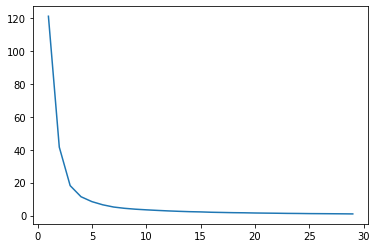

In [ ]:
plt.plot(x, y);

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit(pca_df)
pca_df['clusters'] = clusters.labels_

In [ ]:
pca_df.clusters.value_counts()


0    6340
4     759
3     440
1     194
2      43
Name: clusters, dtype: int64

In [ ]:
#df = df.drop(columns = ['level_0', 'index'])
df.reset_index(inplace = True)

In [ ]:
cluster_df = pd.concat([df, pca_df], axis = 1)


In [ ]:
cluster_df.to_csv('/content/drive/MyDrive/clusterdf.csv', encoding = 'utf-8', index = False)

##pca 군집 시각화

In [ ]:
##위 파일명에 맞게 코드 수정필요
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 8))

for i in range(k):
    plt.scatter(df.loc[df['cluster'] == i, 'duration(min)'], df.loc[df['cluster'] == i, 'root_dist(km)'], 
                label = 'cluster ' + str(i))

plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel('duration(min)', size = 12)
plt.ylabel('root_dist(km)', size = 12)
plt.show()

###평균속도 구하기

In [ ]:
vel = df.iloc[:, 2:16]
cluster_df['time_sum'] = vel.sum(axis = 1)/3600
cluster_df['avg_speed'] = cluster_df['med_est_dist'] / cluster_df['time_sum']

In [ ]:
plt.hist(cluster_df['avg_speed'], bins = 50)

In [ ]:
cluster_df['avg_speed'].describe()

count    6419.000000
mean       37.183828
std        10.143717
min        25.000000
25%        29.285714
50%        35.471204
75%        43.021822
max       101.601942
Name: vel_mean, dtype: float64

In [1]:
##변수명 다시 지정
df = cluster_df

NameError: ignored

###평균속도 분포 분석

In [ ]:
plt.figure(figsize=(15,8))
plt.hist(df.avg_speed, bins=50);

In [ ]:
df['sqrt'] = np.sqrt(df.avg_speed)

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.kdeplot(df.avg_speed);

In [ ]:
plt.figure(figsize=(15,8))
plt.boxplot(df.avg_speed);

In [ ]:
df.avg_speed.describe()

In [ ]:
critical = df['avg_speed'].quantile(q=0.99, interpolation='nearest')
critical

In [ ]:
df2 = df[df['avg_speed'] > critical]
df[df['avg_speed'] > critical].shape[0] / df.shape[0]

In [ ]:
q1 = df['avg_speed'].quantile(0.25)
q2 = df['avg_speed'].quantile(0.5)
q3 = df['avg_speed'].quantile(0.75)
iqr = q3-q1
iqr

In [ ]:
q3+1.5*iqr

In [ ]:
df[df['avg_speed'] > q3+1.5*iqr]

###클러스터 0(단거리 주행)으로 필터링

In [ ]:
df_0 = df[df.clusters == 0]

In [ ]:
sns.kdeplot(df_0.avg_speed);

In [ ]:
df_0.avg_speed.describe()

In [ ]:
critical = df_0['avg_speed'].quantile(q=0.99, interpolation='nearest')
critical

In [ ]:
df3 = df_0[df_0.avg_speed > critical]

###folium을 통해 경로 시각화

In [ ]:
import folium
center = [36.6,126.99]
m= folium.Map(location = center, zoom_start = 12)

In [2]:
##변수명에 맞게 코드 수정필요.

newdf['s'] = newdf[['s_lat','s_lng']].values[:].tolist()
newdf['e'] = newdf[['e_lat','e_lng']].values[:].tolist()


for i in range(len(newdf)):
  line = newdf[['s','e']].values[i].tolist()
  folium.PolyLine(locations = line, tooltip = 'Polyline').add_to(m)

m

NameError: ignored